<a href="https://colab.research.google.com/github/mchivuku/deep-learning-e533/blob/master/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoders

Implementation from the paper - https://arxiv.org/abs/1312.6114 by Kingma and Welling

## Installations

In [0]:
%%capture
!pip install tqdm six


## Connect to google drive

In [9]:
from google.colab import drive

drive.mount("/content/drive")


#%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/examples/vae/
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MNIST/


## Imports

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Params

In [3]:
params = {
    "batch_size":128,
    "epochs" : 10,
    "log_interval":10
    
}

torch.manual_seed(5)

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )



Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## VAE

In [0]:
"""
VAE object
"""
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    
    self.fc1 = nn.Linear(784,400)
    self.fc21 = nn.Linear(400,20) # downsample
    self.fc22 = nn.Linear(400,20)
    self.fc3 = nn.Linear(20,400)
    self.fc4 = nn.Linear(400,784) # input image
    
  ## encode x to latent distribution
  def encode(self,x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)
  
  """"
  Reparameterize - trick
  """
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.rand_like(std)
    return eps.mul(std).add_(mu) ## eps*std + mean
  
  """
  Decode back to original image
  """
  def decode(self,z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))
  
  """
  Forward
  """
  def forward(self,x):
    mu, logvar = self.encode(x.view(-1,784))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar
  
  
  
    
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
  
    

## Loss function

In [0]:
"""
Joint loss over all the parameters
"""
def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction="sum")
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  return BCE + KLD




  

## Train

In [0]:
"""
Train
"""
def train(epoch):
  model.train()
  train_loss = 0
  for batch_idx, (data, _ ) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    
    train_loss+=loss.item()
    
    optimizer.step()
    if batch_idx % params.get("log_interval") == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
      
    print("==> Epoch {}, average loss: {:.4f}".format(epoch, train_loss/len(train_loader.dataset)))
    
    

  

In [0]:
"""
Test
"""
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(params.get("batch_size"), 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

  

In [0]:
## Data Loaders
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST/data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=params.get("batch_size"), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('MNIST/data', train=False, transform=transforms.ToTensor()),
    batch_size=params.get("batch_size"), shuffle=True, **kwargs)


In [27]:
for epoch in range(1, params.get("epochs") + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 102.408340
==> Epoch 1, average loss: 0.2185
==> Epoch 1, average loss: 0.4256
==> Epoch 1, average loss: 0.6407
==> Epoch 1, average loss: 0.8491
==> Epoch 1, average loss: 1.0668
==> Epoch 1, average loss: 1.2746
==> Epoch 1, average loss: 1.4774
==> Epoch 1, average loss: 1.6833
==> Epoch 1, average loss: 1.8931
==> Epoch 1, average loss: 2.1070
Train Epoch: 1 [1280/60000 (2%)]	Loss: 102.203964
==> Epoch 1, average loss: 2.3250
==> Epoch 1, average loss: 2.5291
==> Epoch 1, average loss: 2.7329
==> Epoch 1, average loss: 2.9521
==> Epoch 1, average loss: 3.1604
==> Epoch 1, average loss: 3.3689
==> Epoch 1, average loss: 3.5830
==> Epoch 1, average loss: 3.7869
==> Epoch 1, average loss: 3.9917
==> Epoch 1, average loss: 4.2042
Train Epoch: 1 [2560/60000 (4%)]	Loss: 93.972252
==> Epoch 1, average loss: 4.4047
==> Epoch 1, average loss: 4.6149
==> Epoch 1, average loss: 4.8272
==> Epoch 1, average loss: 5.0388
==> Epoch 1, average loss: 5.2403
==> 

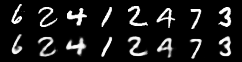

In [34]:

from IPython.display import Image
Image(filename='results/reconstruction_10.png') 



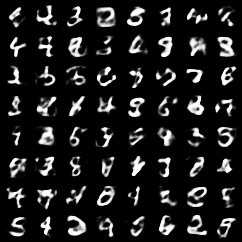

In [35]:
Image(filename='results/sample_10.png') 
